# **PACKAGES**

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_DIR = os.getcwd()
if not ROOT_DIR.endswith('sendy_scripts'):
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    
os.chdir(ROOT_DIR)

from src.processors import Preprocessor
from src.models import XGB_Model, LGB_Model
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_validate

.

# **DATA LOADING**

In [28]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")
riders = pd.read_csv("../data/Riders.csv")
submission = pd.read_csv("../data/SampleSubmission.csv")

# **DATA PREPROCESSING**

In [29]:
train, target = Preprocessor().separate_train_target(train)

In [30]:
train = Preprocessor().preprocess_data(train, True)
test = Preprocessor().preprocess_data(test, False)

In [31]:
all_data = Preprocessor().join_train_test(train, test)

In [32]:
all_data = Preprocessor().le_matrix(all_data)

In [33]:
all_data = all_data.drop("Pickup - Time", axis=1)

In [16]:
all_data.head()

,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Rider Id,is_train,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,Order No
0,3376,2,0,8,4,8,4,8,4,8,4,369,1,4,-1.317755,36.830370,-1.300406,36.829741,Order_No_4211
1,1430,2,1,11,4,11,4,11,4,11,4,834,1,16,-1.351453,36.899315,-1.295004,36.814358,Order_No_25375
2,1835,2,0,29,1,29,1,29,1,29,1,63,1,3,-1.308284,36.843419,-1.300921,36.828195,Order_No_1899
3,450,2,0,14,4,14,4,14,4,14,4,833,1,9,-1.281301,36.832396,-1.257147,36.795063,Order_No_9336
4,821,0,1,12,0,12,0,12,0,12,0,740,1,9,-1.266597,36.792118,-1.295041,36.809817,Order_No_27883


In [35]:
#all_data = all_data.astype("int64")

In [36]:
train, test = Preprocessor().separate_train_test(all_data)

.

# **MODELIZATION**

## **XGBOOST**

In [51]:
dtrain = XGB_Model().prepare_data(train, target)
dtest = XGB_Model().prepare_data(test, None)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [39]:
xgb_params = {
    'max_depth': 4, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'nthread'  : 4,
    'eval_metric' : "rmse",
}

In [40]:
cv_rmse_xgb = XGB_Model().train_xgb_cv(dtrain, params=xgb_params, nfold=6, num_boost_round=1000)

In [41]:
print("Argmin is:", np.argmin(cv_rmse_xgb['test-rmse-mean']), "and the minimum is :", np.min(cv_rmse_xgb['test-rmse-mean']))

Argmin is: 396 and the minimum is : 764.6959023333333


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [45]:
xgb_num_boost = np.argmin(cv_rmse_xgb['test-rmse-mean'])

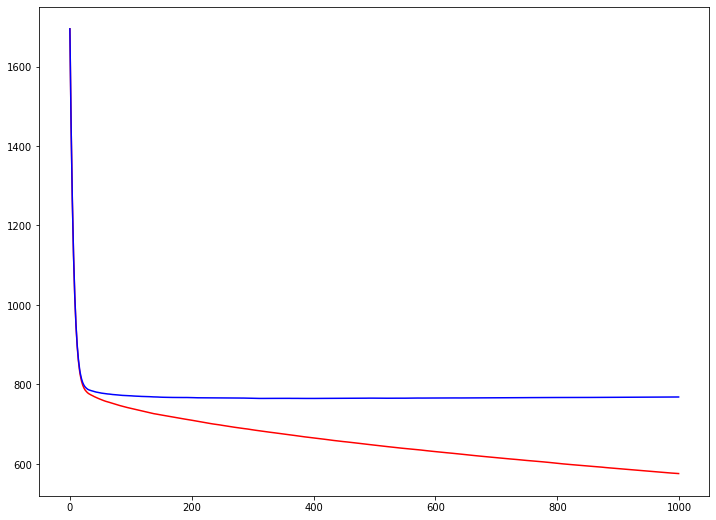

In [42]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] + cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] - cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] + cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] - cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")

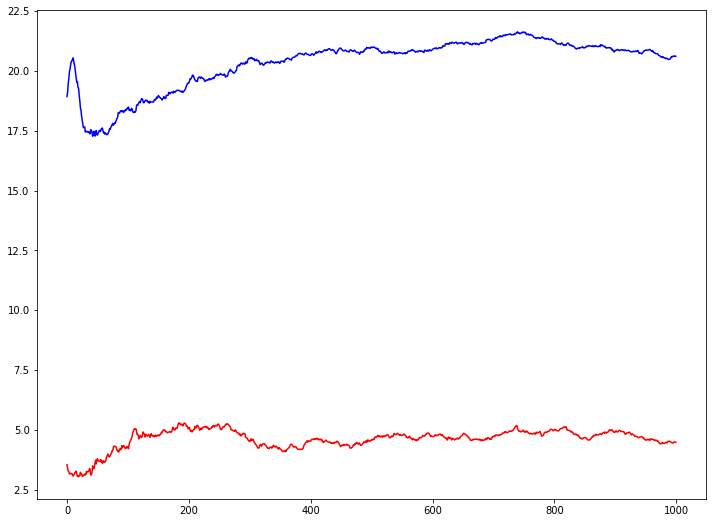

In [43]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-std'], color="red")
plt.plot(cv_rmse_xgb['test-rmse-std'], color="blue")

In [46]:
xgb_model = XGB_Model().train_xgb(dtrain,  xgb_params, xgb_num_boost)

In [52]:
xgb_pred = xgb_model.predict(dtest)
xgb_pred_train = xgb_model.predict(dtrain)

In [53]:
xgb_submission = submission
xgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(xgb_pred[3:])


/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
xgb_submission.to_csv("../submissions/XgBoost_Le_join_train_test.csv", index=False)

.

## LightGBM

In [55]:
dtrain = LGB_Model().prepare_data(train[list(test.columns)], target)
dtest = LGB_Model().prepare_data(test, None)

In [56]:
lgb_params = {
    'boosting': "gbdt", 
    'learning_rate': 0.1, 
    'objective': 'regression',
    'num_threads'  : 4,
    'metric' : "rmse",
}

In [57]:
cv_rmse_lgb = LGB_Model().train_lgb_cv(dtrain, params=lgb_params, nfold=10, num_boost_round=1000)

In [17]:
for key in cv_rmse_lgb.keys():
    print(key)

rmse-mean
rmse-stdv


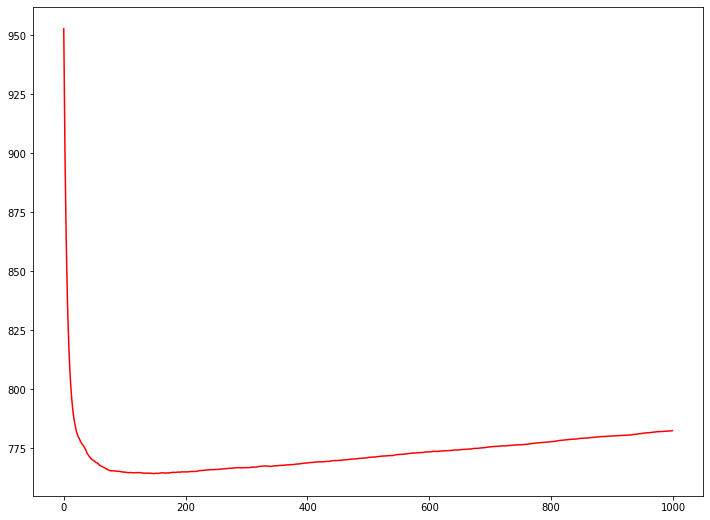

In [58]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_lgb['rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")

In [59]:
print("Argmin is:", np.argmin(cv_rmse_lgb['rmse-mean']), "and the minimum is :", np.min(cv_rmse_lgb['rmse-mean']))

Argmin is: 148 and the minimum is : 764.3065064434082


In [60]:
lgb_num_boost = np.argmin(cv_rmse_lgb['rmse-mean'])

In [61]:
lgb_model = LGB_Model().train_lgb(dtrain,  lgb_params, lgb_num_boost)

In [62]:
#lgb_pred = lgb_model.predict(test.drop("Order No", axis=1))
#lgb_pred_train = lgb_model.predict(train.drop("Order No", axis=1))

lgb_pred = lgb_model.predict(test)
lgb_pred_train = lgb_model.predict(train)

In [63]:
lgb_submission = submission
lgb_submission["Time from Pickup to Arrival"].loc[3:] = np.round(lgb_pred[3:])


In [64]:
lgb_submission.to_csv("../submissions/Lgbm_Le_join_train_test.csv", index=False)

# **STACKING LGB AND XGB**

In [21]:
lgb_pred

array([1685.49646494, 1223.18659448, 1222.66285245, ..., 1618.77193428,
       2626.73693584, 1882.21894482])

In [22]:
xgb_pred

array([1313.0885, 1296.8817, 1214.0266, ..., 1852.8407, 2400.1885,
       1871.9578], dtype=float32)

In [43]:
X_stack = np.vstack((lgb_pred_train, xgb_pred_train)).T

In [53]:
X_stack[0,:]

array([1219.49834678,  608.81115723])

In [45]:
lasso_stck = Lasso(alpha=0.1)

cv_results = cross_validate(lasso_stck, X_stack, target, cv=6)


In [47]:
cv_results["test_score"]

array([0.66518768, 0.65087828, 0.66530051, 0.68168959, 0.68510739,
       0.66369297])

In [48]:
lasso_stck = lasso_stck.fit(X_stack, target)

In [49]:
lasso_stck_pred = lasso_stck.predict(np.vstack((lgb_pred, xgb_pred)).T)

In [50]:
lasso_stck_submission = submission
lasso_stck_submission["Time from Pickup to Arrival"].loc[3:] = np.round(lasso_stck_pred[3:])
lasso_stck_submission.to_csv("../submissions/Lasso_Stack_1.csv", index=False)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
